<a href="https://colab.research.google.com/github/Mansisarda1999/A-star-search/blob/main/CV_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
import numpy as np
from utils import generate_hough_space_v1, get_ylines
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def get_lines(file):
  image = np.array(Image.open(file).convert('L'))
  binary_image = image < 250

  list_theta = np.linspace(np.deg2rad(89), np.deg2rad(91), 100)
  print('Run Hough Transform and 5 line detection')
  accumulator, list_rho, list_theta, list_distance, n_lines = generate_hough_space_v1(binary_image, 1, 8, 30, 5, list_theta = list_theta)
  print('Hough transform done.')
  list_ys, list_rs, list_ts, d = get_ylines(accumulator, list_rho, list_theta, list_distance)
  print('Result:')
  print('\t# of 5 parallel lines (as group):', len(list_ys))
  print(f'\tY axis for first line in 5 lines: {list_ys}')
  print('\tDistance between each lines:', d)

  # Make plot
  scale_width = 1
  scale_height = 1

  max_size = 10
  height, width = image.shape[0] / max(image.shape), image.shape[1] / max(image.shape)

  figsize = (height*max_size, width*max_size)
  figsize = (40,40)
  fig, ax = plt.subplots(figsize = figsize, dpi = 100)
  ax.imshow(image)

  for y,r,t in zip(list_ys, list_rs, list_ts):
      for i in range(n_lines):
          origin = np.arange(0, image.shape[1])
          ys = ((r + (i * d)) - origin * np.cos(t)) / np.sin(t)
          valid_index = (ys>0) & (ys<image.shape[0])
          ys = ys[valid_index]
          origin = origin[valid_index]
          x1, x2 = origin[0]/scale_width, origin[-1]/scale_width
          y1, y2 = ys[0]/scale_height, ys[-1]/scale_height
          # plot a line
          ax.plot([x1, x2], [y1, y2], color = 'red')
  plt.show()
  return list_ys,d

In [3]:
def patch_corr(template, img):
    image = img.point(lambda x: 1 - x)
    arr = np.zeros((image.size[1], image.size[0]))
    np_img,np_template = np.asarray(image),np.asarray(template.point(lambda x: 1 - x))
    for i in range(image.size[1] - template.size[1] + 1):
        for j in range(image.size[0] - template.size[0] + 1):
            end,end2=i+template.size[1],j+template.size[0]
            cross = np.sum(np_img[i: end, j: end2] * np_template) 
            arr[i + template.size[1]//2, j + template.size[0]//2] = cross
    return arr

def NMS(image_temp, col, row):
    for i in range(image_temp.shape[0] - col + 1):
        for j in range(image_temp.shape[1] - row + 1):
            temp_matrix = image_temp[i:(i + col), j : (j + row)]
            if temp_matrix.max() != temp_matrix[col//2, row//2] or (temp_matrix == temp_matrix.max()).sum()>1:
                temp_matrix[col//2, row//2] = 0
    return image_temp

def find_centers(file_name):
  t1 = Image.open(f'/content/template1.png').convert('L')
  t2 = Image.open(f'/content/template2.png').convert('L')
  t3 = Image.open(f'/content/template3.png').convert('L')
  img = Image.open(file_name).convert('L')
  img=img.convert('1')
  t1=t1.convert('1')
  t2=t2.convert('1')
  t3=t3.convert('1')
  out1 = patch_corr(t1, img)
  out2 = patch_corr(t2, img)
  out3 = patch_corr(t3, img)
  nms_out1 = NMS(out1, t1.size[1], t1.size[0])
  nms_out2 = NMS(out2, t2.size[1], t2.size[0])
  nms_out3 = NMS(out3, t3.size[1], t3.size[0])
  centerx1, centery1 = np.where(nms_out1 > 0.80*np.max(out1))
  centerx2, centery2 = np.where(nms_out2 > 0.80*np.max(out2))
  centerx3, centery3 = np.where(nms_out3 > 0.80*np.max(out3))
  list_center1=[]
  for x,y in zip(centerx1,centery1):
    center = [y,x]
    list_center1.append(center)
  list_center1 = np.array(list_center1)

  list_center2=[]
  for x,y in zip(centerx2,centery2):
    center = [y,x]
    list_center2.append(center)
  list_center2 = np.array(list_center2)

  list_center3=[]
  for x,y in zip(centerx3,centery3):
    center = [y,x]
    list_center3.append(center)
  list_center3 = np.array(list_center3)
  list_notes = []
  list_row = []
  list_col = []
  list_height = []
  list_width = []
  list_symbol_type = []
  list_confidence = []
  reference_notes = ['e', 'd', 'c', 'b', 'a','g'] + ['f','e','d','c','b','a','g','f','e','d'] + ['c', 'b', 'a', 'g']
  line_from = -3
  line_to = 7
  list_ys,d = get_lines(file_name)
  for y in list_ys:
      refernece_ys = []
      for idx, i in enumerate(range(line_from, line_to)):
          refernece_ys.append(y+d*i)
          refernece_ys.append(y+d*i+d/2)
      refernece_ys = np.array(refernece_ys)
      centers = list_center1[(list_center1[:,1]<=refernece_ys[-1]) & (list_center1[:,1]>=refernece_ys[0])]
      centers = np.array(sorted(centers, key = lambda x: x[0]))
      for c in centers:
          list_notes.append(reference_notes[np.argmin(abs(np.array(refernece_ys) - c[1]))])
          list_row.append(c[0] - t1.size[1]//2)
          list_col.append(c[1] - t1.size[0]//2)
          list_height.append(t1.size[0])
          list_width.append(t1.size[1])
          list_symbol_type.append('filled_note')
          list_confidence.append(1)
  
  for y in list_ys:
      refernece_ys = []
      centers = np.array(sorted(list_center2, key = lambda x: (x[0], x[1])))
      for c in centers:
          list_notes.append('_')
          list_row.append(c[0]-t2.size[0]//2)
          list_col.append(c[1]-t2.size[0])
          list_height.append(t2.size[0])
          list_width.append(t2.size[1])
          list_symbol_type.append('rest1')
          list_confidence.append(1)

  for y in list_ys:
      refernece_ys = []
      centers = np.array(sorted(list_center3, key = lambda x: (x[0], x[1])))
      for c in centers:
          list_notes.append('_')
          list_row.append(c[0]-t3.size[0]//2)
          list_col.append(c[1]-t3.size[0])
          list_height.append(t3.size[0])
          list_width.append(t3.size[1])
          list_symbol_type.append('rest2')
          list_confidence.append(1)    

  import pandas as pd
  output = pd.DataFrame({
          'note': list_notes,
          'row': list_row,
          'col': list_col,
          'height': list_height,
          'width': list_width,
          'symbol': list_symbol_type,
          'confidence': list_confidence
      })
  list_notes = output['note'].values
  list_col = output['col'].values
  list_row = output['row'].values
  list_height = output['height'].values
  list_width = output['width'].values
  list_symbols = output['symbol'].values
  fig, ax = plt.subplots(figsize = (40,40))
  image = np.array(Image.open(file_name).convert('L'))
  ax.imshow(image, cmap = 'gray')
  for i in range(len(list_notes)):
      note = list_notes[i]
      symbol = list_symbols[i]
      row = list_row[i]
      col = list_col[i]
      height = list_height[i]
      width = list_width[i]
      if symbol == 'filled_note':
        rect = patches.Rectangle((row, col), height,width, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.annotate(str(note), xy = (row, col), xytext=(row-8, col), color = 'red', fontsize = 25)
      if symbol == 'rest1':
        rect = patches.Rectangle((row, col), height,width, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.annotate(str(note), xy = (row, col), xytext=(row-8, col), color = 'blue', fontsize = 25)
      if symbol == 'rest2':
        rect = patches.Rectangle((row, col), height,width, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.annotate(str(note), xy = (row, col), xytext=(row-8, col), color = 'green', fontsize = 25)
        # else:
      #     rect = patches.Rectangle((row, col), width, height, linewidth=1, edgecolor='blue', facecolor='none')
      #     ax.add_patch(rect)

Run Hough Transform and 5 line detection
Running Hough transform...
	# of theta searching space: 100
	# of distance searching space: 100
	3D accumulator shape: (2588, 100, 22)
Hough transform done.
Result:
	# of 5 parallel lines (as group): 2
	Y axis for first line in 5 lines: [29, 151]
	Distance between each lines: 12


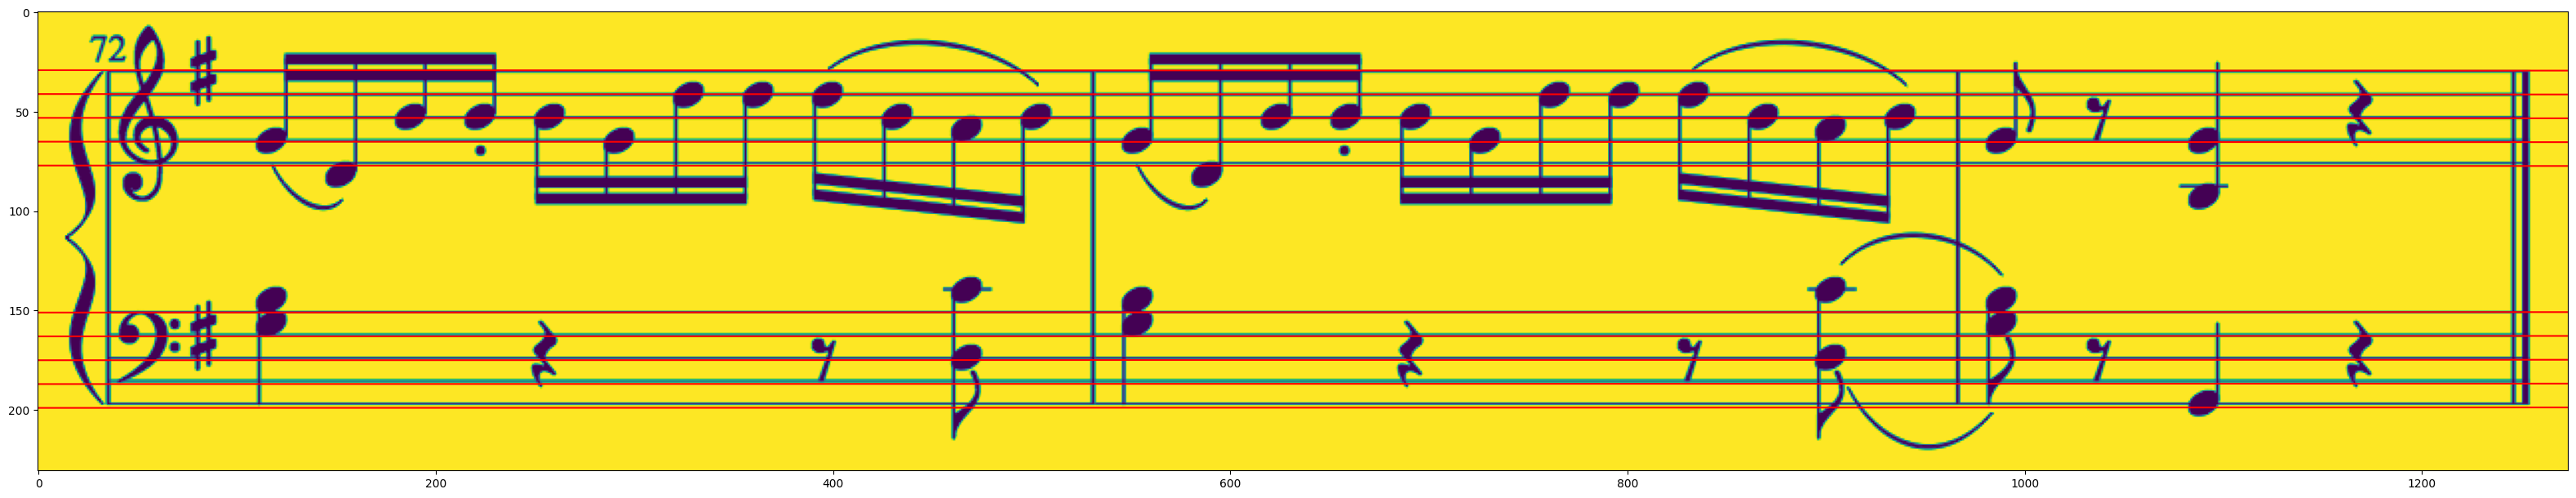

In [4]:
find_centers('/content/music1.png')

Run Hough Transform and 5 line detection
Running Hough transform...
	# of theta searching space: 100
	# of distance searching space: 100
	3D accumulator shape: (2968, 100, 22)
Hough transform done.
Result:
	# of 5 parallel lines (as group): 2
	Y axis for first line in 5 lines: [79, 225]
	Distance between each lines: 13


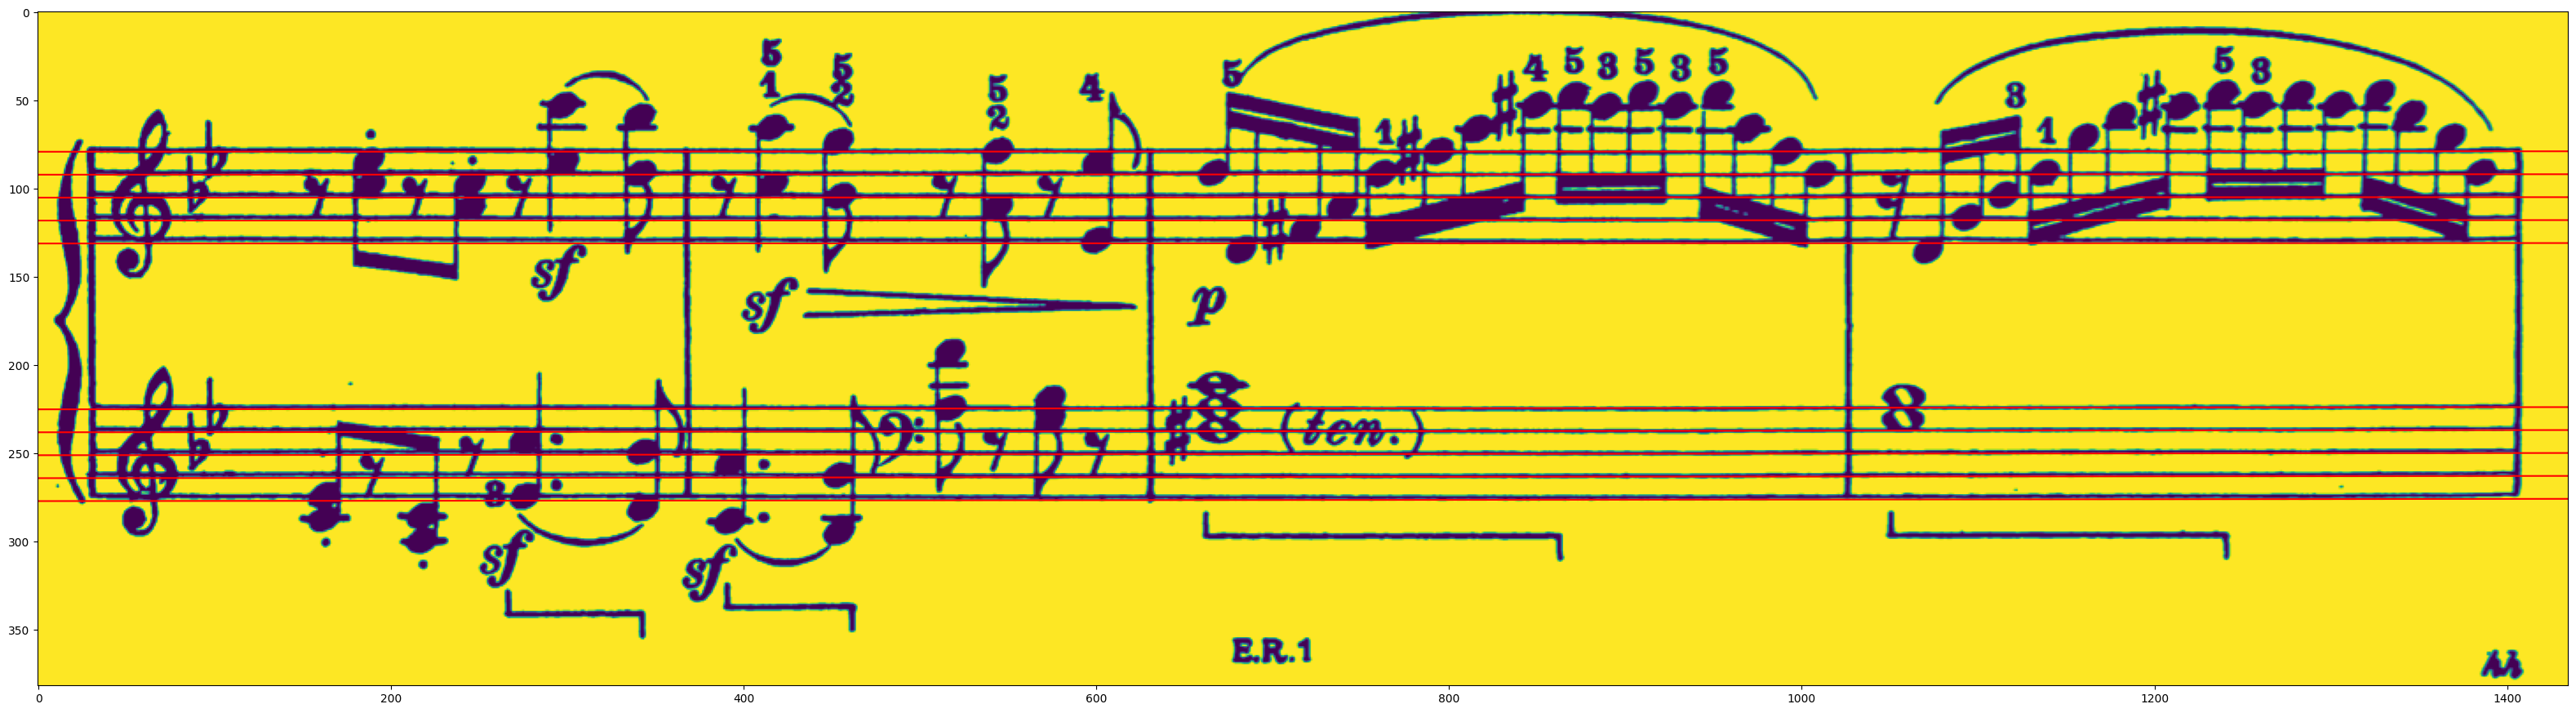

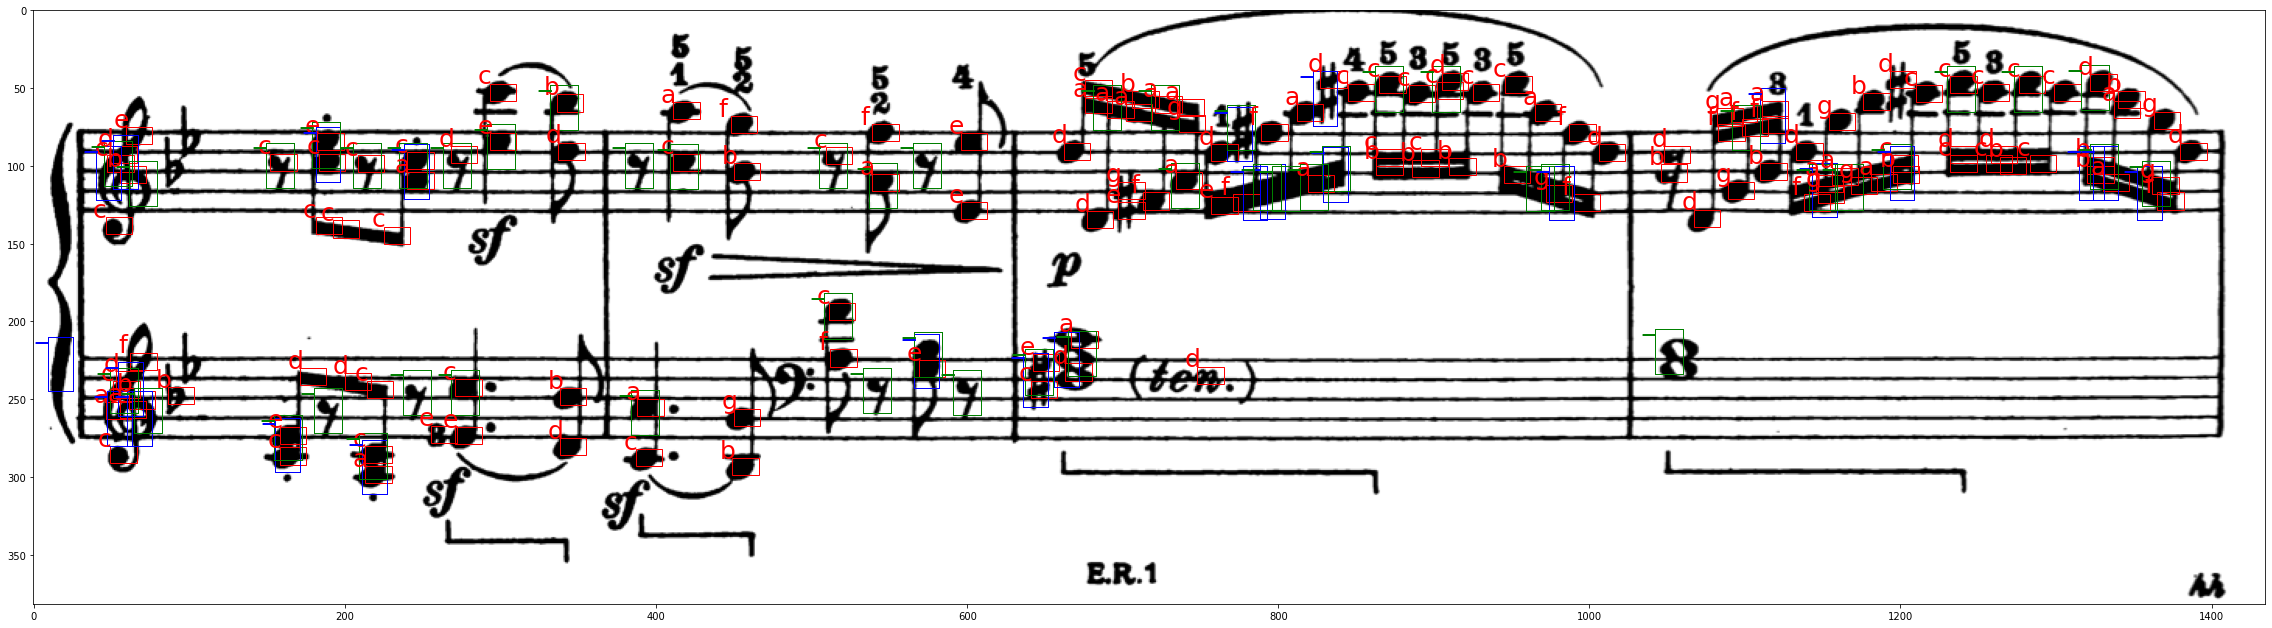

In [5]:
find_centers('/content/music2.png')

Run Hough Transform and 5 line detection
Running Hough transform...
	# of theta searching space: 100
	# of distance searching space: 100
	3D accumulator shape: (2602, 100, 22)
Hough transform done.
Result:
	# of 5 parallel lines (as group): 4
	Y axis for first line in 5 lines: [405, 305, 53, 153]
	Distance between each lines: 10


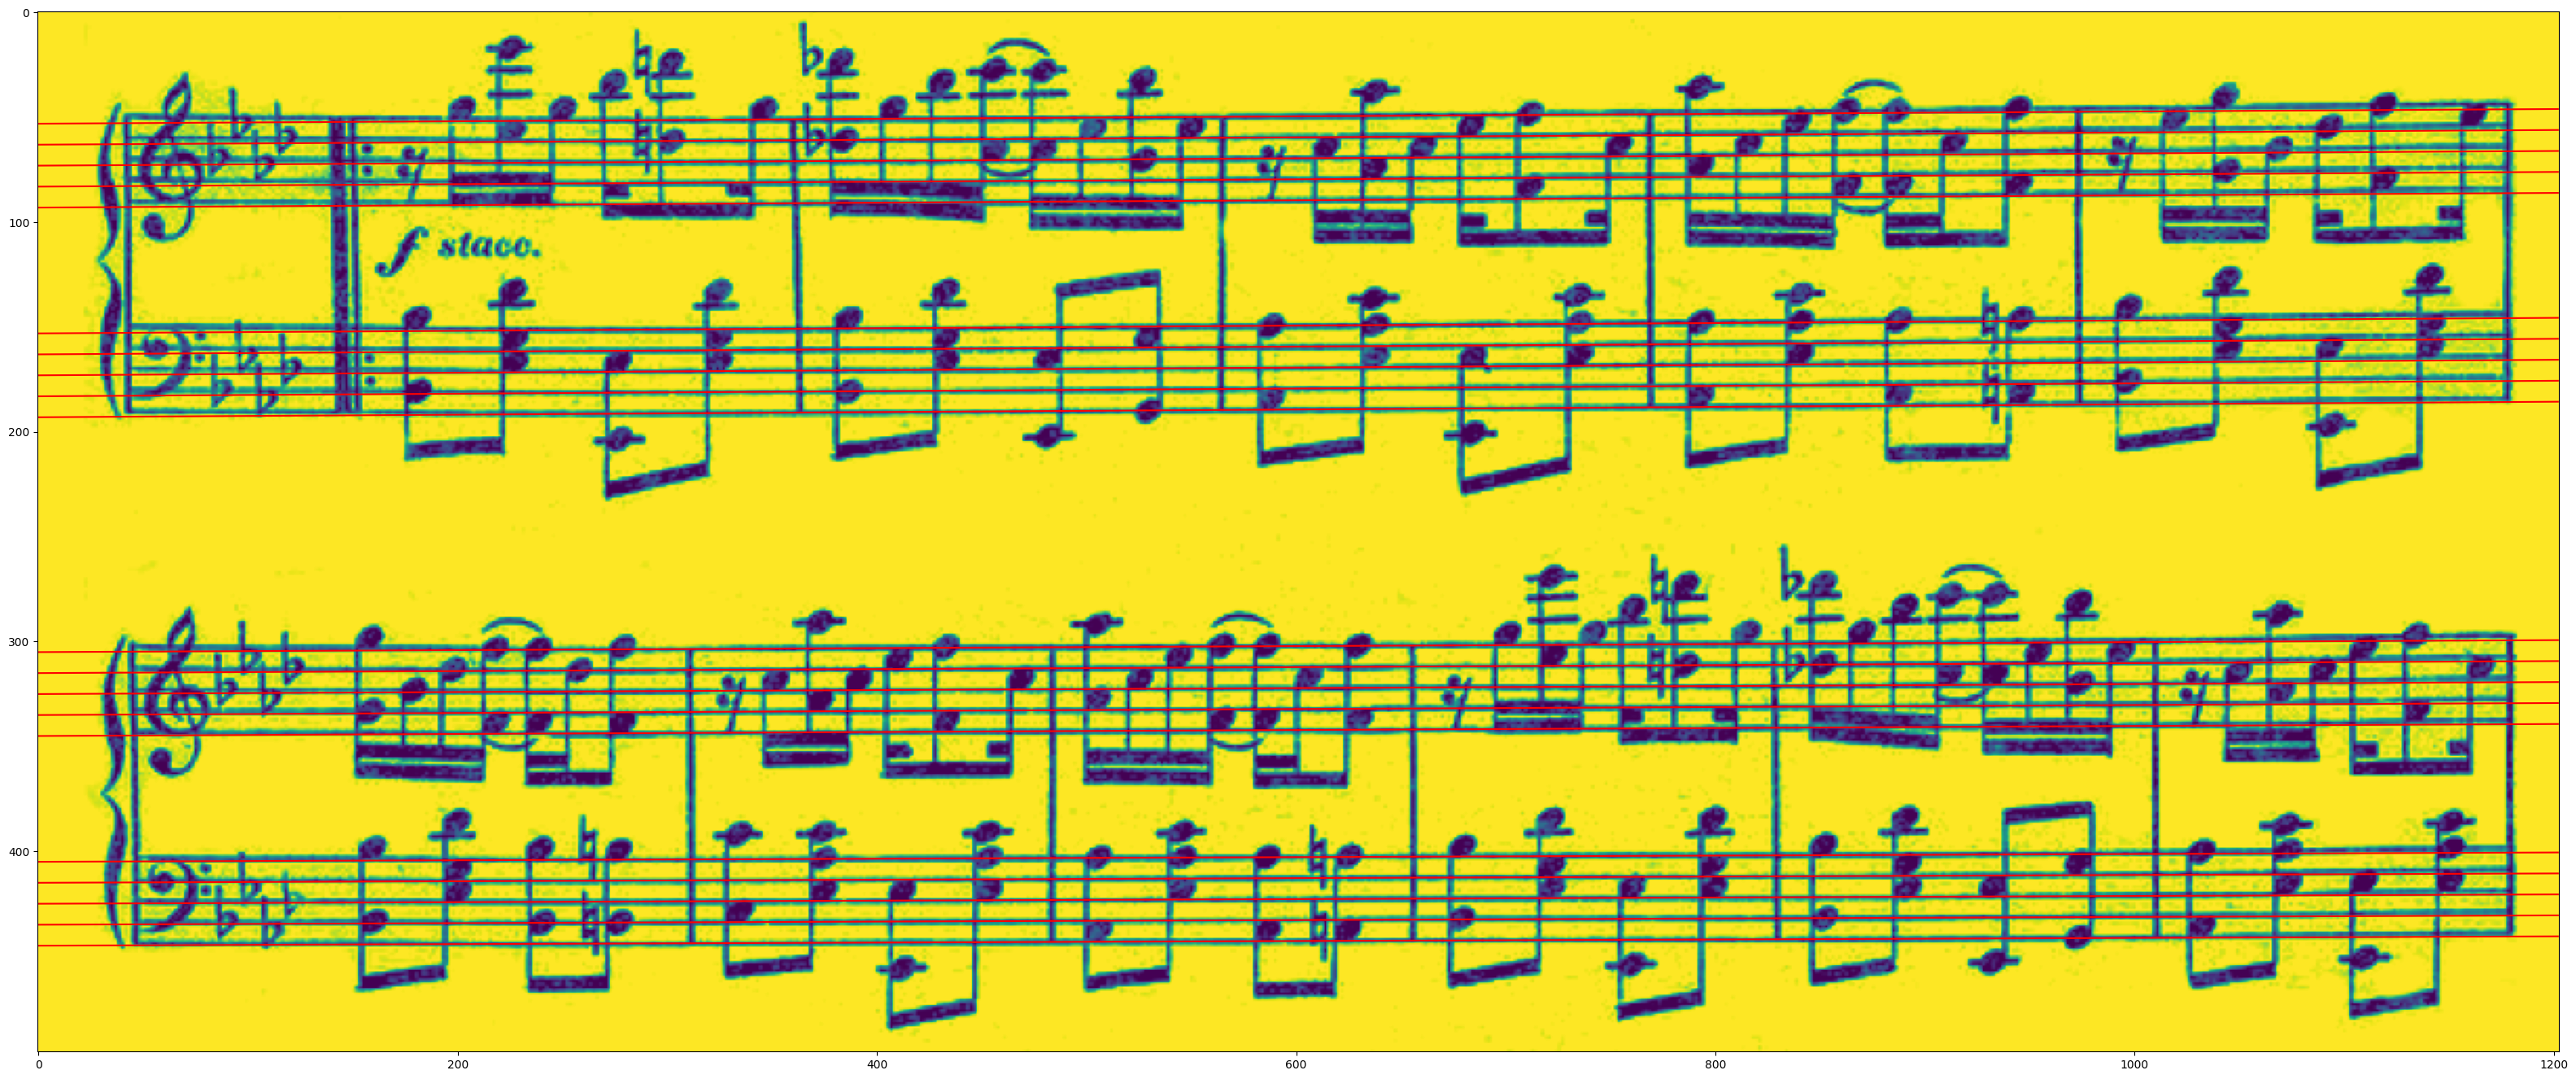

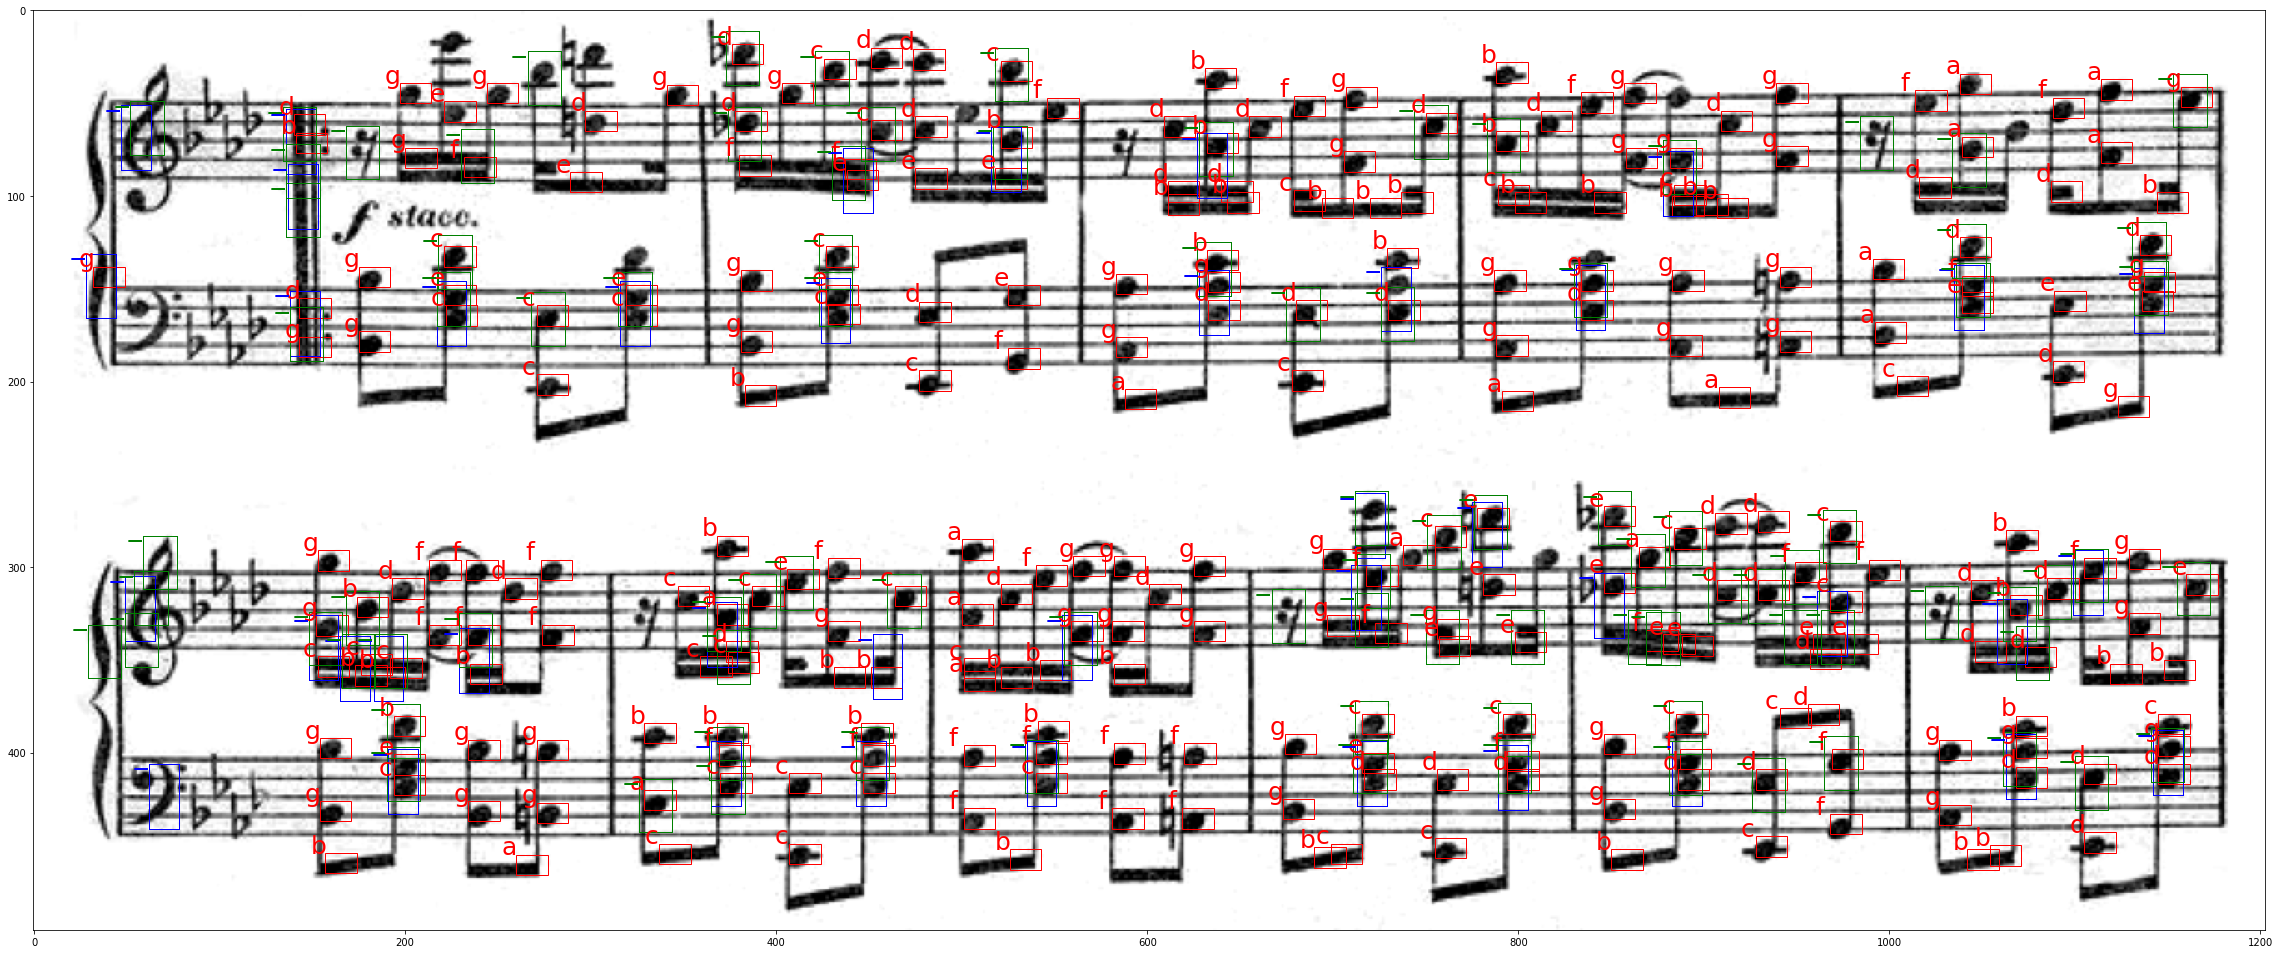

In [6]:
find_centers('/content/music3.png')

Run Hough Transform and 5 line detection
Running Hough transform...
	# of theta searching space: 100
	# of distance searching space: 100
	3D accumulator shape: (3720, 100, 22)
Hough transform done.
Result:
	# of 5 parallel lines (as group): 2
	Y axis for first line in 5 lines: [265, 55]
	Distance between each lines: 17


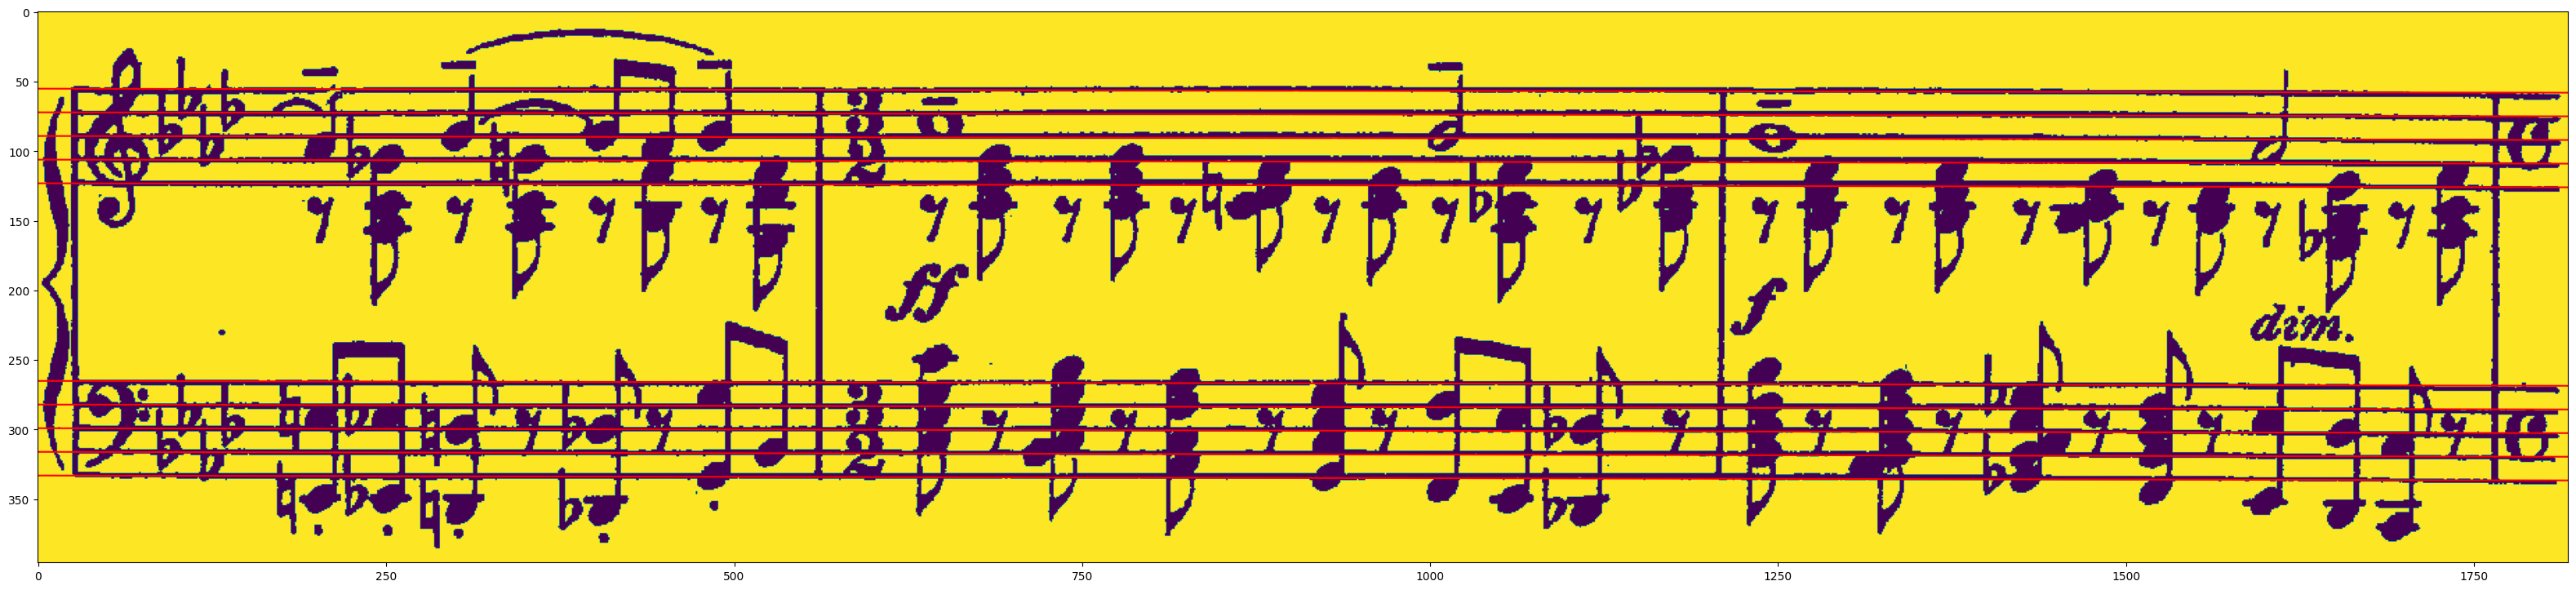

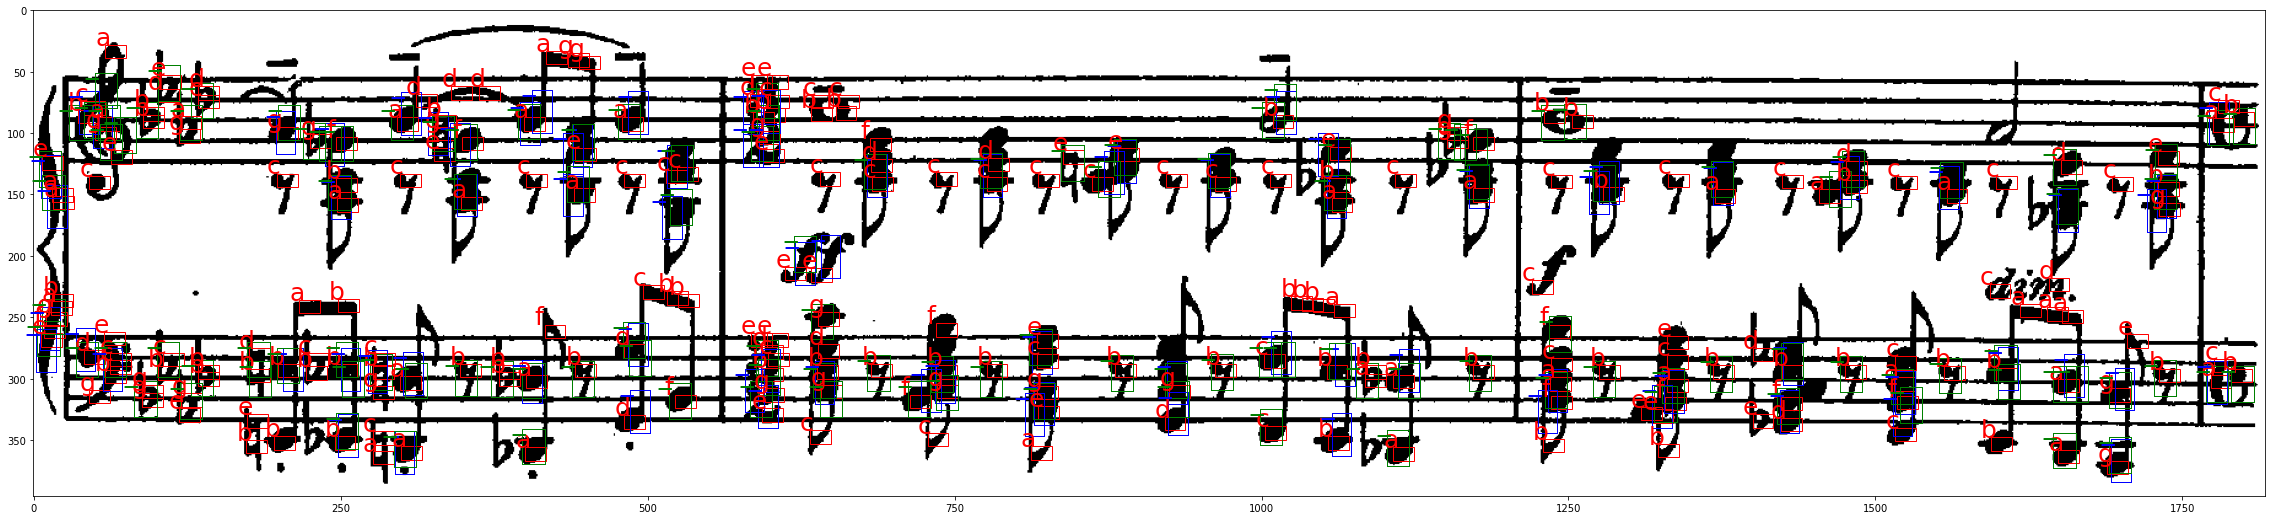

In [7]:
find_centers('/content/music4.png')